In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from plotting_utils import *
import torch
import numpy as np
from pathlib import Path
from guided_diffusion import *
from dataset import CustomDataset


In [2]:
diffusion = create_gaussian_diffusion()
data_folder = Path( r'C:\Users\smerino.C084288\Documents\simulatedCystDataset\downs800_0.0Att')
input_folder = data_folder/'input_testing'
output_folder = data_folder/'target_from_raw'
# input_folder = r'C:\Users\sebas\Documents\Data\DiffusionBeamformer\input_overfit'
# output_folder = r'C:\Users\sebas\Documents\Data\DiffusionBeamformer\target_overfit'

data = CustomDataset(input_folder, output_folder, transform=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))


In [3]:
id = 249
data.output_file_list = data.input_file_list
x_sample, y_sample = data.__getitem__(id)
x_sample = x_sample.unsqueeze(0).to(device)
y_sample = y_sample.unsqueeze(0).to(device)

In [4]:
len(data)

2500


###  A. Not residual, no attention

Num params:  32676097


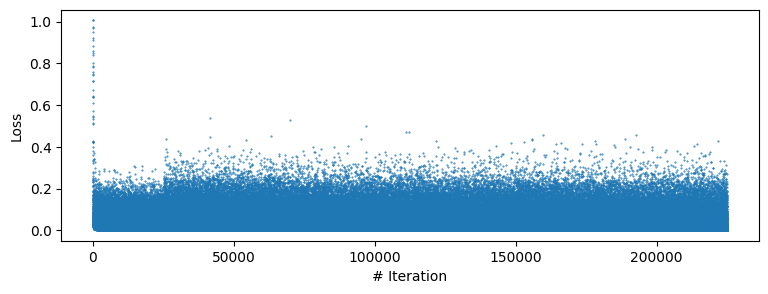

In [5]:
from model import UNETv13
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

save_dir = r'.\weights'
training_epochs = 100 # 20 for initial version
model13A = UNETv13(residual=False, attention_res=[], group_norm=False).to(device)

# save_dir = r'.\weightsGN'
# training_epochs = 70
# model13A = UNETv13(residual=False, attention_res=[], group_norm=True).to(device)
# 

model13A.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model13A.parameters()))

plt.figure(figsize=(9, 3))
loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))], loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
# plt.xlim(000,35000)
# plt.ylim(0, 0.01)
plt.show()

In [6]:
intermediate = []
for step in diffusion.p_sample_loop_progressive(model13A, y_sample.shape, x_sample, progress=True, clip_denoised=True):
    intermediate.append(step['sample'].cpu().detach())
np.save('intermediateGN.npy',np.array(intermediate).squeeze())

# np.load('intermediateGN.npy')

  0%|          | 0/1000 [00:00<?, ?it/s]

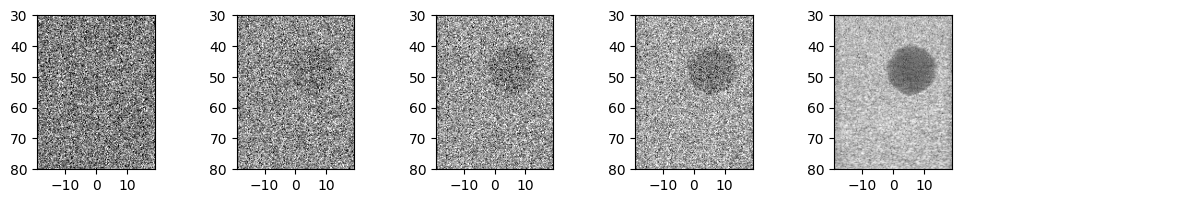

In [11]:
plt.figure(figsize=(15,2))
plt.axis('off')

plt.subplot(1, 6, 1)
show_tensor_image(intermediate[0])

plt.subplot(1, 6, 2)
show_tensor_image(intermediate[500])

plt.subplot(1, 6, 3)
show_tensor_image(intermediate[600])

plt.subplot(1, 6, 4)
show_tensor_image(intermediate[700])

plt.subplot(1, 6, 5)
show_tensor_image(intermediate[-1])

plt.savefig('intermediateBN.svg')
plt.savefig('intermediateBN.png')
plt.show()

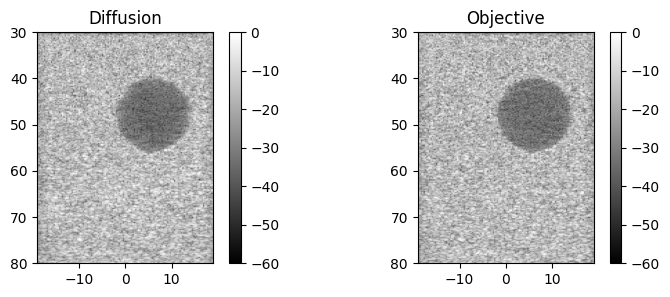

In [13]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
show_tensor_image(intermediate[-1])
plt.colorbar()
plt.title('Diffusion')

plt.subplot(1, 2, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.title('Objective')
plt.show()
